In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, fftpack
from matplotlib.colors import LogNorm

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [2]:
value = 15
mu = 6.3
values = np.arange(0,value+1)

distr = stats.poisson.pmf(values, mu)

prob = 1 - distr.sum()

print("\nP(15+ hurricanes):\t%2.2e"%prob)

Z=(value - mu)/np.sqrt(mu)

print("\nZ score:\t\t%2.2f"%Z)

print("\nSince the Z score is major than 3, assuming a Poisson distribution, 15 hurricanes is a significantly different number from the historic average.")


P(15+ hurricanes):	8.44e-04

Z score:		3.47

Since the Z score is major than 3, assuming a Poisson distribution, 15 hurricanes is a significantly different number from the historic average.


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [3]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
pre_m=np.mean(pre)
post_m=np.mean(post)
pre_sig=np.std(pre)
post_sig=np.std(post)
sig=((pre_sig**2+post_sig**2)/2)**0.5

T=(post_m-pre_m)/(sig*0.2**0.5)
print("\nThe value of the T-student test is %2.2f" %T)

pval = stats.t.cdf(T, 9) + stats.t.sf(-T, 9)
print("\nThe pval, 2-sided, is %2.2e, it is minor than a significance alpha of 0.05. So the null hypothesis is rejected." % pval)


The value of the T-student test is 3.99

The pval, 2-sided, is 2.00e+00, it is minor than a significance alpha of 0.05. So the null hypothesis is rejected.


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

In [4]:
data = pd.read_csv("populations.txt", delimiter='\t')
display(data[0:3])

# fft
hare_fft = fftpack.fft(data['hare'].values)
lynx_fft = fftpack.fft(data['lynx'].values)
carrot_fft = fftpack.fft(data['carrot'].values)

freq = fftpack.fftfreq(data.shape[0], d=1)

hare_power = np.abs(hare_fft)
carrot_power = np.abs(carrot_fft)
lynx_power = np.abs(lynx_fft)

,# year,hare,lynx,carrot
0,1900,30000.0,4000.0,48300
1,1901,47200.0,6100.0,48200
2,1902,70200.0,9800.0,41500


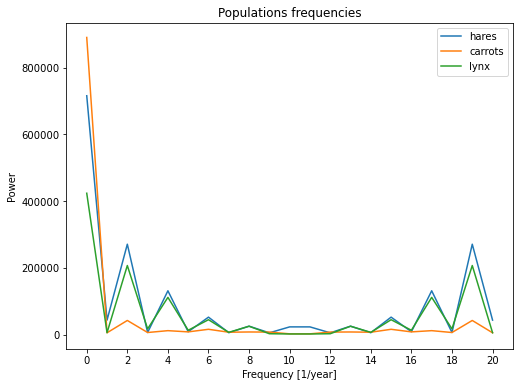

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(hare_power, label='hares')
plt.plot(carrot_power, label='carrots')
plt.plot(lynx_power, label='lynx')
plt.xticks(np.arange(0,22,2))
plt.title('Populations frequencies')
plt.xlabel('Frequency [1/year]')
plt.ylabel('Power')
plt.legend()
plt.show()


In [6]:
# peak frequency
pos_mask = np.where(freq > 0)
freqs = freq[pos_mask]
powes_h = hare_power[pos_mask]
powes_l = lynx_power[pos_mask]
peak_freq_h = freqs[powes_h.argmax()]
peak_freq_l = freqs[powes_l.argmax()]
print("Hare peak frequency: %2.4f"% peak_freq_h)
print("Lynx peak frequency: %2.4f"% peak_freq_l)


#second frequency
pos2_mask = np.where(freqs < 0.09)
freqs2 = freqs[pos2_mask]
powes2_h = hare_power[pos2_mask]
powes2_l = lynx_power[pos2_mask]
peak_freq2_h = freqs2[powes2_h.argmax()]
peak_freq2_l = freqs2[powes2_l.argmax()]
print("Second hare frequency: %2.4f"% peak_freq2_h)
print("Second lynx frequency: %2.4f"% peak_freq2_l)

print("\nThe domininant signal is the constant signal.\nThe period with the highest power is in both cases %2.1f years.\nThe second high power frequency is exactly the half of the first one."%(1/peak_freq_h))

Hare peak frequency: 0.0952
Lynx peak frequency: 0.0952
Second hare frequency: 0.0476
Second lynx frequency: 0.0476

The domininant signal is the constant signal.
The period with the highest power is in both cases 10.5 years.
The second high power frequency is exactly the half of the first one.


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

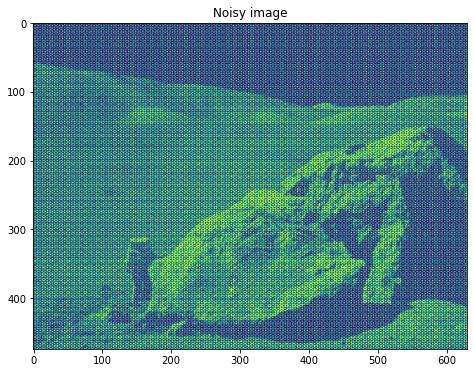

In [7]:
# import and view noisy image
file_name="/home/lorenzo/Programming/CompLabA/LaboratoryOfComputationalPhysics_Y4/moonlanding.png"
moonl = plt.imread(file_name)
plt.figure(figsize=(8, 6))
plt.imshow(moonl)
plt.title("Noisy image")
plt.show()

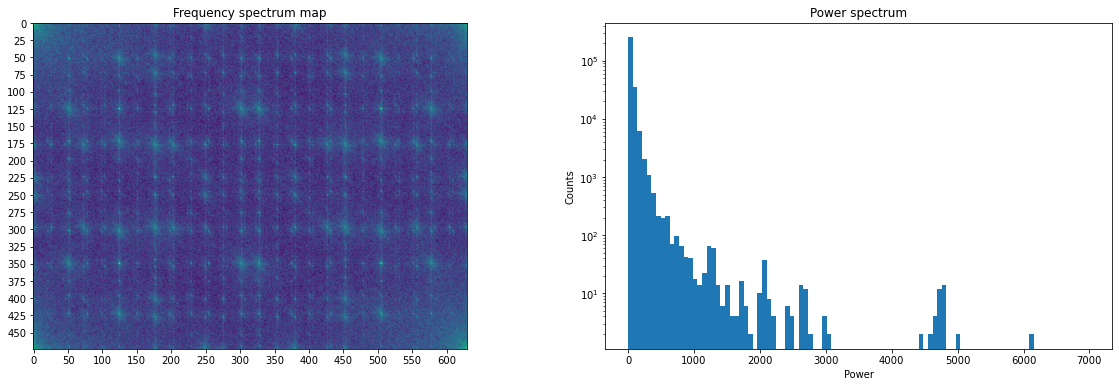

In [9]:
# FFT, 2D frequency spectrum
fig, axs = plt.subplots(1,2,figsize=(20,6))
moonl_fft = fftpack.fft2(moonl)
axs[0].imshow(np.abs(moonl_fft), norm=LogNorm(vmin=5))
axs[0].set_title("Frequency spectrum map")

# histogram
axs[1].hist(np.abs(moonl_fft.ravel()), bins=100, log=True, range=(0,7000))
axs[1].set_xlabel("Power")
axs[1].set_ylabel("Counts")
axs[1].set_title("Power spectrum")
axs[0].set_xticks(np.arange(0,630,50))
axs[0].set_yticks(np.arange(0,474,25))

plt.show()

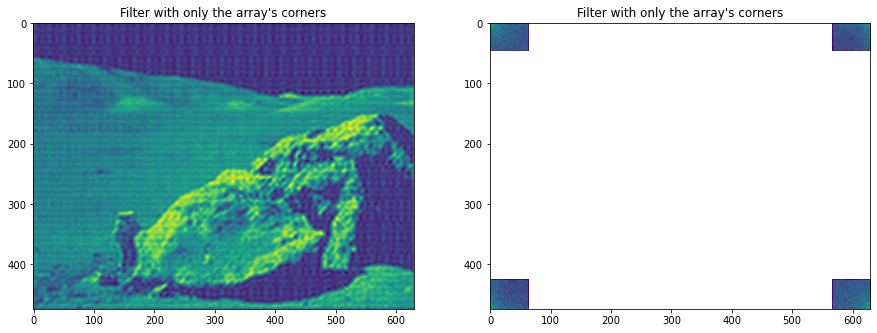

In [11]:
# Keeping only the best region of the array
img_fft = moonl_fft.copy()
nrows,ncols = img_fft.shape
sq = 0.1

img_fft[int(nrows*sq):int(nrows*(1-sq)),:] = 0
img_fft[:,int(ncols*sq):int(ncols*(1-sq))] = 0
clean_img = fftpack.ifft2(img_fft)

fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(np.real(clean_img))
axs[0].set_title("Filter with only the array's corners")

axs[1].imshow(np.abs(img_fft), norm=LogNorm(vmin=5))
axs[1].set_title("Filter with only the array's corners")

plt.show()

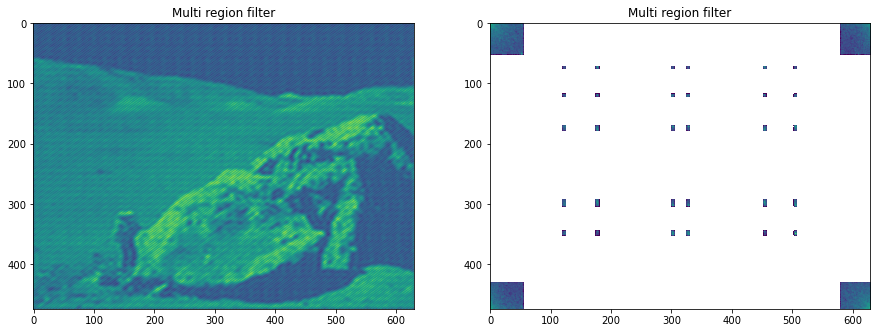

In [12]:
# Keeping every good region of the array
img_fft = moonl_fft.copy()

img_fft[:,55:120] = 0
img_fft[:,125:175] = 0
img_fft[:,180:300] = 0
img_fft[:,305:325] = 0
img_fft[:,330:453] = 0
img_fft[:,457:503] = 0
img_fft[:,507:580] = 0

img_fft[53:73,:] = 0
img_fft[77:119,:] = 0
img_fft[123:171,:] = 0
img_fft[179:293,:] = 0
img_fft[304:345,:] = 0
img_fft[352:420,:] = 0
img_fft[420:430,:] = 0

img_fft[65:425,0:55] = 0
img_fft[65:425,550:] = 0
img_fft[0:55,100:510] = 0
img_fft[430:,100:510] = 0

clean_img = fftpack.ifft2(img_fft)

# plot results
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(np.real(clean_img))
axs[0].set_title("Multi region filter")

axs[1].imshow(np.abs(img_fft), norm=LogNorm(vmin=5))
axs[1].set_title("Multi region filter")

plt.show()

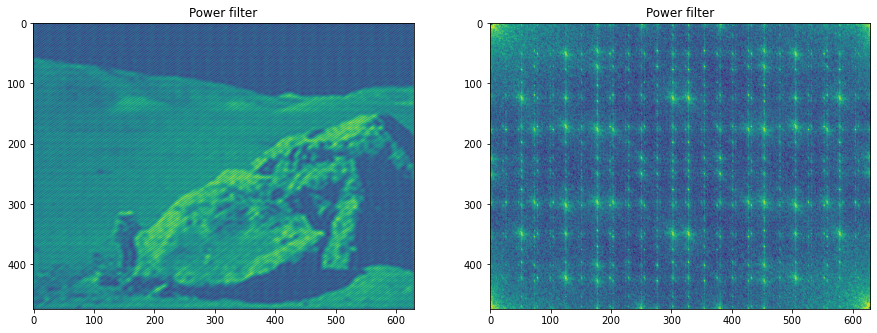

In [13]:
# Filtering the power
img_fft = moonl_fft.copy()

img_fft[np.abs(img_fft)>1500] = 0

clean_img_p = fftpack.ifft2(img_fft)

# plot results
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(np.real(clean_img))
axs[0].set_title("Power filter")

axs[1].imshow(np.abs(img_fft), norm=LogNorm(vmin=5))
axs[1].set_title("Power filter")

plt.show()

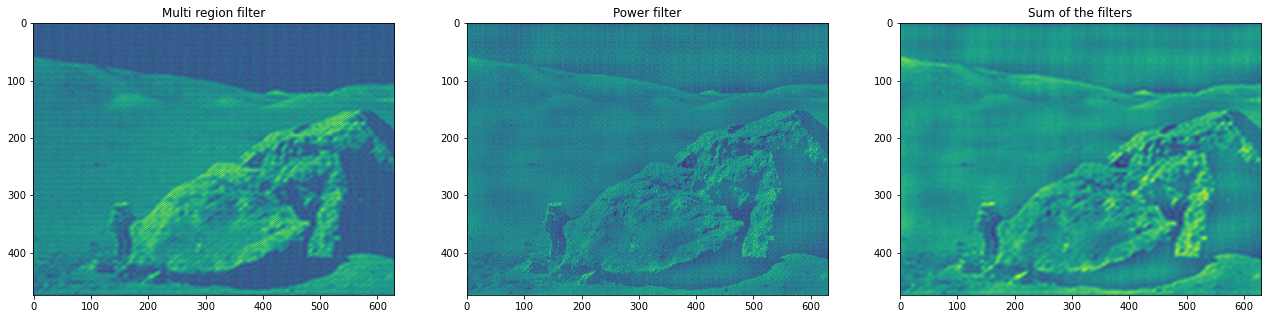

In [14]:
# Power filter on the selected parts of the array
img_fft = moonl_fft.copy()

img_fft[:,55:120] = 0
img_fft[:,125:175] = 0
img_fft[:,180:300] = 0
img_fft[:,305:325] = 0
img_fft[:,330:453] = 0
img_fft[:,457:503] = 0
img_fft[:,507:580] = 0

img_fft[53:73,:] = 0
img_fft[77:119,:] = 0
img_fft[123:171,:] = 0
img_fft[179:293,:] = 0
img_fft[304:345,:] = 0
img_fft[352:420,:] = 0
img_fft[420:430,:] = 0

img_fft[65:425,0:55] = 0
img_fft[65:425,550:] = 0
img_fft[0:55,100:510] = 0
img_fft[430:,100:510] = 0

img_fft[np.abs(img_fft)>1500] = 0

clean_img_sum = fftpack.ifft2(img_fft)

# plot results
fig, axs = plt.subplots(1,3,figsize=(22,8))
axs[2].imshow(np.real(clean_img_sum))
axs[2].set_title("Sum of the filters")

axs[1].imshow(np.real(clean_img_p))
axs[1].set_title("Power filter")

axs[0].imshow(np.real(clean_img))
axs[0].set_title("Multi region filter")

plt.show()

In [15]:
print("The strategy of manually selecting the best parts of the arrays succedds in cancelling the noise. As expected, it \nworks better when selecting a high number of smaller parts. \nThe problem is that too many small details in the image are lost, making the image blurred. The efficiency of this \nstrategy is very far from the one of the filter that automatically selects the frequencies with low power. \nIn fact in the last image we see that the sum of the filters has nearly the same noise as the sum of the filters, \nbut is much less blurred.")

The strategy of manually selecting the best parts of the arrays succedds in cancelling the noise. As expected, it 
works better when selecting a high number of smaller parts. 
The problem is that too many small details in the image are lost, making the image blurred. The efficiency of this 
strategy is very far from the one of the filter that automatically selects the frequencies with low power. 
In fact in the last image we see that the sum of the filters has nearly the same noise as the sum of the filters, 
but is much less blurred.
